### Wikiart: Deep Convolutional (DC) Generative Adverserial Network (GAN)

### Load Libraries

In [ ]:
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils import data
from torch.utils.data import DataLoader
from google.colab import drive
import argparse
import os
from os import walk
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
import sys
import tensorflow as tf
from torch import autograd


### Mount Google Drive

In [ ]:
# mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Metric Modules

In [ ]:
# load inception score metric
inception_path = '/content/drive/MyDrive/neural_networks/modules/inception_score_pytorch'
#!cat '/content/drive/MyDrive/neural_networks/modules/inception_score_pytorch/inception_score.py'
sys.path.append(inception_path)
from inception_score import inception_score
frechet_path = '/content/drive/MyDrive/neural_networks/modules/frechet_inception_distance'
#!cat '/content/drive/MyDrive/neural_networks/modules/frechet_inception_distance/frechet_inception_distance.py'
sys.path.append(frechet_path)
from frechet_inception_distance import frechet_id

### Training Parameters

In [ ]:
num_epochs = 200
batch_size = 64
learning_rate = 1e-4
use_gpu = True
img_size = 64
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
tolerance = 1e-6
# use smaller wiki art data for testing
use_test_data = True

### Load Subset Wikiart Data

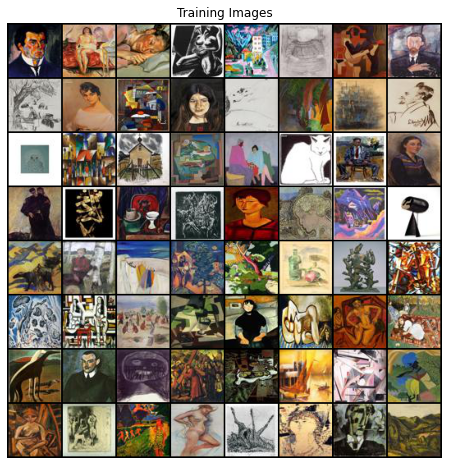

In [ ]:
# print subfolders/art styles of the wikiart subset directory
#!ls '/content/drive/MyDrive/neural_networks/data/wikiart_resized'
# set parent folder of wikiart as file directory
if use_test_data == True:
    data_dir = '/content/drive/MyDrive/neural_networks/data/wikiart_subset'

elif use_test_data == False:
    data_dir = '/content/drive/MyDrive/neural_networks/data/wikiart_resized'

# set random seed
random.seed(1486438)
torch.manual_seed(1486438)

# define transformer for data loader
# resize and normalize data for slight performance boost
img_transform = transforms.Compose([
                                    transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), 
                                                         (0.5, 0.5, 0.5))
                                  ])

dataset = datasets.ImageFolder(root=data_dir,
                           transform=img_transform)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

### Custom Weight Initialization

In [ ]:
# custom weights initialization called on netG and netD
# set random seed
random.seed(1486438)
torch.manual_seed(1486438)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Gan Parameters

In [ ]:
# number of channels (1 = gray, 3 = RGB colors)
nc = 3
# number/size of latent vector z for the generator input
nz = 100
# size/number of feature maps in generator
ngf = 64
# size/number of feature maps in discriminator
ndf = 64
# define fixed noise to sample images from the latent space of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # input to conv. lay. : length of latent vector z 
        self.deconv1 = nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False)
        self.deconv1_bn = nn.BatchNorm2d(ngf*8)
        # state size: (ngf * 8) x 4 x 4
        self.deconv2 = nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False)
        self.deconv2_bn = nn.BatchNorm2d(ngf*4)
        # state size: (ngf * 4) x 8 x 8
        self.deconv3 = nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False)
        self.deconv3_bn = nn.BatchNorm2d(ngf*2)
        # state size: (ngf * 2) x 16 x 16
        self.deconv4 = nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False)
        self.deconv4_bn = nn.BatchNorm2d(ngf)
        # state size: (ngf) x 32 x 32
        self.deconv5 = nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False)
        # state size: (nc) x 64 x 64

    def forward(self, input):
        x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))
        # x = torch.sigmoid(self.deconv5(x))
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # input to conv. lay. : (nc) x 64 x 64
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv1_bn = nn.BatchNorm2d(ndf)
        # state size: (ndf) x 32 x 32
        self.conv2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)
        self.conv2_bn = nn.BatchNorm2d(ndf*2)
        # state size: (ndf * 2) x 16 x 16
        self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)
        self.conv3_bn = nn.BatchNorm2d(ndf*4)
        # state size: (ndf * 4) x 8 x 8
        self.conv4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)
        self.conv4_bn = nn.BatchNorm2d(ndf*8)
        # state size: (ndf * 8) x 4 x 4
        self.conv5 = nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input))
        x = F.leaky_relu(self.conv1_bn(self.conv1(input)), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))
        return x
    
generator = Generator()
discriminator = Discriminator()

# apply the weights_init function to randomly initialize all weights
# to mean=0, stdev=0.02
# set random seed
#random.seed(1486438)
#torch.manual_seed(1486438)
generator.apply(weights_init)
discriminator.apply(weights_init)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 3576704 and discriminator: 2765696


### Define Storage Location

In [ ]:
# mount google drive for saving checkpoints
drive.mount('/content/drive')

# checkpoint generator file name
gen_save_name = 'wikiart_dc_gen.cpt'
# define location to store checkpoints for generator
path_gen = F'/content/drive/MyDrive/neural_networks/checkpoints/{gen_save_name}'

# checkpoint discriminator file name
disc_save_name = 'wikiart_dc_disc.cpt'
# define location to store checkpoints for discriminator
path_disc = F'/content/drive/MyDrive/neural_networks/checkpoints/{disc_save_name}'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Custom Loss

In [ ]:
def mse_custom_loss(output, target):
    loss = torch.mean((output - target)**2)
    print(loss)
    return loss

def bce_custom_loss2(y_pred, y_true):
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    loss = torch.mean(y_true*torch.logit(y_pred) + (1.0-y_true)*torch.logit(1.0-y_pred))
    #loss=y_true*torch.log2(y_pred) + (one_torch-y_pred)*torch.log2(one_torch-y_pred)
    #loss = torch.mean((y * torch.log(x) + (1.0 - y) * torch.log(1.0 - x)))
    return loss

def sig(x):
  return 1 / (1 + torch.exp(-x))

def bce_custom_loss(x , y):
    # loss = torch.mean(-y * torch.log(x) - (1.0-y) * torch.log(1.0 - x))
    loss = torch.mean(-y * torch.clamp(torch.log(x), min = -100) - (1.0-y) * torch.clamp(torch.log(1.0 - x),min = -100))
    return loss

### Train GAN

In [ ]:
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate,
                                 betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate,
                                  betas=(0.5, 0.999))
# set to training mode
generator.train()
discriminator.train()

# loss per iteration
gen_iter_loss = []
disc_iter_loss = []
#loss per epoch
gen_loss_avg = []
disc_loss_avg = []

gen_loss_avg.append(0)
disc_loss_avg.append(0)

iters = 0
switch = True

# store generated images 
img_lst = []
# store generated images for gif
img_lst_gif = []

print('Training ...')
for epoch in range(num_epochs):
    # start countine time 
    start_time = time.time() 
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, i in dataloader:
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), nz, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        #if switch == True:
        #    print("real pred:", real_pred[:10])
        #    print("fake_pred:", fake_pred[:10])
        #    print("label_real:", label_real[:10])
        #    print("label_fake:", label_fake[:10])
        #    switch = False
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        # loss per iteration
        gen_iter_loss.append(gen_loss.item())
        disc_iter_loss.append(disc_loss.item())

        # average loss per iteration to obtain average loss per epoch
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1
        # every 127 batches give print statement
        if num_batches % 127 == 0:
            print('Epoch [%d / %d], batch [%d / %d]: average loss generator vs. discrim.: %f vs. %f [%s seconds]' %
          (epoch+1, num_epochs, num_batches, len(dataloader), gen_loss_avg[-1], disc_loss_avg[-1], round(time.time() - start_time,3)))
            print('No. of sample images stored: [%d]' % len(img_lst))
        # Save generated image if: 
        # 1) at the first iteration
        # 2) final epoch has been reached
        # 3) a full batch of training passed i.e one epoch has passed
        elif (iters == 1) or (epoch == num_epochs) or (iters % len(dataloader) == 0):
            # turn off gradient descent computation to minimize computation cost
            with torch.no_grad():
                # generate fake image from generator
                fake = generator(fixed_noise).detach().cpu()
            # store image
            img_lst.append(fake)
            # store image for gif
            img_lst_gif.append(vutils.make_grid(fake, padding=2, normalize=True))
            print('No. of sample images stored: [%d]' % len(img_lst))
        iters += 1
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
    # after each epoch print current epoch, generator and discriminator loss and runtime per epoch
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f [%s seconds]'  %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1], round(time.time() - start_time,3)))
    # after each epoch save generator, epochs, loss and images
    print('Generator Checkpoint Saved [%d / %d]' % (epoch + 1, num_epochs))
    torch.save({
            'epoch': epoch,
            'gen_state_dict': generator.state_dict(),
            'optimizer_state_dict': gen_optimizer.state_dict(),
            'gen_loss_avg': gen_loss_avg,
            'gen_iter_loss': gen_iter_loss,
            'img_lst': img_lst,
            'img_lst_gif': img_lst_gif,
            }, path_gen)
    # after each epoch save discriminator, epochs and loss
    print('Discriminator Checkpoint Saved [%d / %d]' % (epoch + 1, num_epochs))
    torch.save({
            'epoch': epoch,
            'disc_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': disc_optimizer.state_dict(),
            'disc_loss_avg': disc_loss_avg,
            'disc_iter_loss': disc_iter_loss,
            }, path_disc)
    # if difference between current average loss and previous average loss smaler 
    # than tolerance value stop training
    if (abs(disc_loss_avg[-1] - disc_loss_avg[-2]) <= tolerance) or (abs(gen_loss_avg[-1] - gen_loss_avg[-2]) <= tolerance):
        print('Generator or Discriminator reached an average loss of approximately 0.')
        print('One of the advaseries/players won the min-max game.')
        print('The game is over.')
        break

Training ...
real pred: tensor([0.8114, 0.2695, 0.8771, 0.4360, 0.7581, 0.8822, 0.6321, 0.5566, 0.6454,
        0.4139], device='cuda:0', grad_fn=<SliceBackward>)
fake_pred: tensor([0.0541, 0.5377, 0.8052, 0.8737, 0.3856, 0.2496, 0.2741, 0.3890, 0.1179,
        0.7338], device='cuda:0', grad_fn=<SliceBackward>)
fake_pred: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
fake_pred: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
No. of sample images stored: [1]
No. of sample images stored: [2]
Epoch [1 / 200], batch [127 / 144]: average loss generator vs. discrim.: 832.064966 vs. 24.214530 [2678.104 seconds]
No. of sample images stored: [2]
Epoch [1 / 200] average loss generator vs. discrim.: 6.608390 vs. 0.188403 [3014.797 seconds]
Generator Checkpoint Saved [1 / 200]
Discriminator Checkpoint Saved [1 / 200]
No. of sample images stored: [3]
Epoch [2 / 200], batch [127 / 144]: average loss generator vs. discrim.: 810.971237 vs. 22.668316 [19.115 second

### Load Checkpoints

In [ ]:
# load models
disc_save_name = 'wikiart_dc_gen.cpt'
gen_save_name = 'wikiart_dc_disc.cpt'

path_gen = F'/content/drive/MyDrive/neural_networks/checkpoints/{gen_save_name}'
path_disc = F'/content/drive/MyDrive/neural_networks/checkpoints/{disc_save_name}'

# check whether checkpoint files exist
if os.path.isfile(path_gen) and os.path.isfile(path_disc) == True:
    checkpoint_gen = torch.load(path_gen)
    checkpoint_disc = torch.load(path_disc)

    # neural net is saved on the gpu we send it to the cpu via .to(device)
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    # given the kernel shut done and all variables are lost
    # optimizers need to be initialised again
    gen_optimizer = torch.optim.Adam(params=generator.parameters(), 
                                     lr=learning_rate, betas=(0.5, 0.999))
    disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), 
                                      lr=learning_rate, betas=(0.5, 0.999))
    generator.load_state_dict(checkpoint_gen['gen_state_dict'])
    discriminator.load_state_dict(checkpoint_disc['disc_state_dict'])
    gen_optimizer.load_state_dict(checkpoint_gen['optimizer_state_dict'])
    disc_optimizer.load_state_dict(checkpoint_disc['optimizer_state_dict'])
    epoch = checkpoint_gen['epoch']
    img_lst = checkpoint_gen['img_lst']
    img_lst_gif = checkpoint_gen['img_lst_gif']
    gen_loss_avg = checkpoint_gen['gen_loss_avg']
    disc_loss_avg = checkpoint_disc['disc_loss_avg']
else: 
    print("Checkpoint files not found or do not exist.")
    print("The neural network may have not been trained yet.")
#model_gen.eval()
# - or -
#model_gen.train()

KeyError: ignored

### Figures: First and Last Image

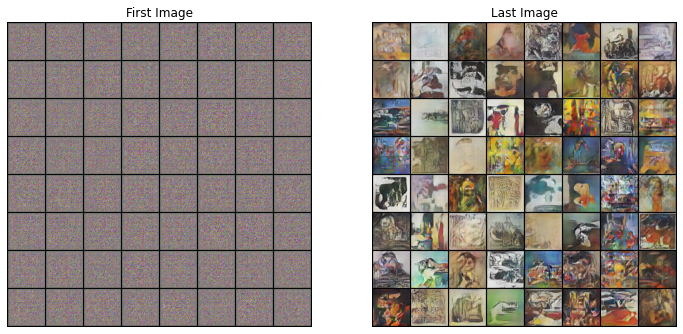

In [ ]:
# plot 1st image
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("First Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
# plot last image
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Last Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[-1].to(device), padding=2, normalize=True).cpu(),(1,2,0)))

### Plot: Real Images vs Generated Images

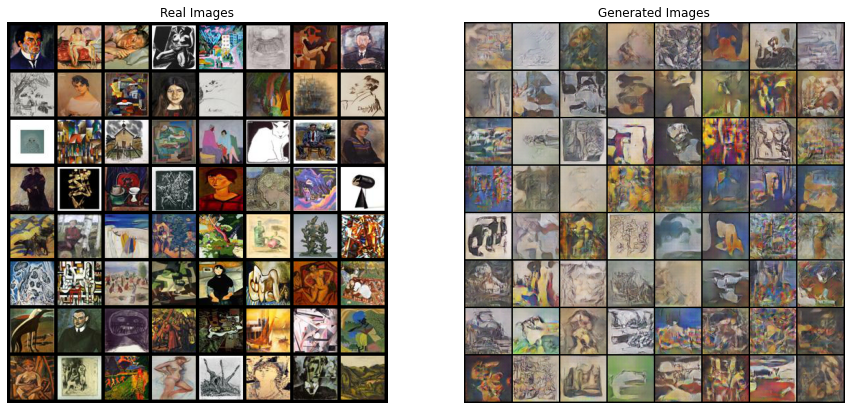

In [ ]:
# Grab a batch of real images from the dataloader
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, 
                                         normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_lst_gif[-1].cpu().numpy(),(1,2,0)))
plt.show()

### Gif: Image Generation Process

In [ ]:
# gif from starting image to last generated image
#%%capture
# if bytes for gif are too big increase limit 
plt.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu().numpy(),(1,2,0)), animated=True)] for i in img_lst_gif]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

### Training Curves

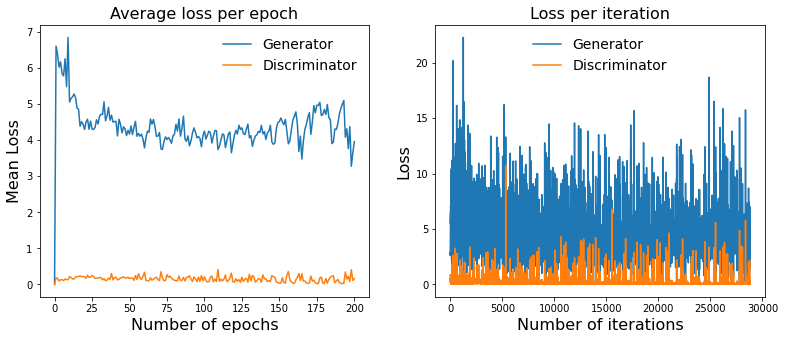

In [ ]:
# Plot average loss per epoch
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(gen_loss_avg, linewidth=1.5)
plt.plot(disc_loss_avg, linewidth=1.5)
plt.title('Average loss per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Mean Loss', fontsize = 16)
plt.legend(['Generator', 'Discriminator'], 
           prop={'size': 14},           
            frameon=False)

# Plot loss per iteration
plt.subplot(1,2,2)
plt.plot(gen_iter_loss, linewidth=1.5)
plt.plot(disc_iter_loss, linewidth=1.5)
plt.title('Loss per iteration', fontsize = 16)
plt.xlabel('Number of iterations', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.legend(['Generator', 'Discriminator'], 
           prop={'size': 14},           
            frameon=False)
plt.show()

### Image Evaluation Metrics

Inception score

In [ ]:
stedv, means = [], []
imgs = []
for j in range(len(img_lst)):
  for i in range(len(img_lst[j])):
    imgs.append((vutils.make_grid(img_lst[j][i].to(device), padding=2, normalize=True).cpu()))
  if (j % 20 == 0): 
    print('Image metric computed for [%d / %d]' % (j, len(img_lst)))
  mean, stdv = inception_score(imgs, cuda=True, batch_size=32, resize=True, splits=10)
  means.append(mean)
  stedv.append(stdv)

Image metric computed for [0 / 201]


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/content/drive/MyDrive/neural_networks/modules/inception_score_pytorch/inception_score.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


Image metric computed for [20 / 201]
Image metric computed for [40 / 201]
Image metric computed for [60 / 201]
Image metric computed for [80 / 201]
Image metric computed for [100 / 201]
Image metric computed for [120 / 201]
Image metric computed for [140 / 201]
Image metric computed for [160 / 201]
Image metric computed for [180 / 201]
Image metric computed for [200 / 201]


Frechet Inception Distance

In [ ]:
real_batch = next(iter(dataloader))
fids = []
for i in range(len(img_lst)):
  fids.append(frechet_id(img_lst[i], real_batch))

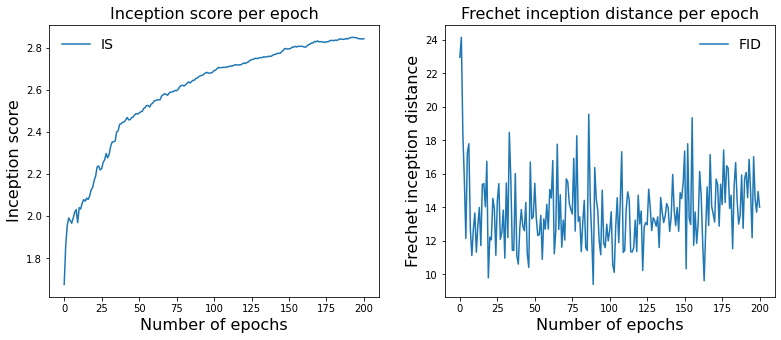

In [ ]:
# Plot average loss per epoch
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(means, linewidth=1.5)
plt.title('Inception score per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Inception score', fontsize = 16)
plt.legend(['IS'], 
           prop={'size': 14},           
            frameon=False)

# Plot loss per iteration
plt.subplot(1,2,2)
plt.plot(fids, linewidth=1.5)
plt.title('Frechet inception distance per epoch', fontsize = 16)
plt.xlabel('Number of epochs', fontsize = 16)
plt.ylabel('Frechet inception distance', fontsize = 16)
plt.legend(['FID'], 
           prop={'size': 14},           
            frameon=False)
plt.show()

NEvAr Metric

In [ ]:

import tensorflow as tf
# convert pytorch tensor to np array
tensor_to_np = img_lst[110].detach().cpu().numpy()
# convert np array to tf tensor
tf_tensor = tf.convert_to_tensor(tensor_to_np)
# set it as image
img = tf_tensor
# perform tf sobel edge operation
grad_components = tf.image.sobel_edges(img)
# compute gradient magnitute 
grad_mag_components = grad_components**2
# sum magnitude components
grad_mag_square = tf.math.reduce_sum(grad_mag_components,axis=-1)
# sobel edge detected image
grad_mag_img = tf.sqrt(grad_mag_square)
# convert tf tensor to np array
tensor_img = grad_mag_img.numpy()
# plot sobel operaiton on image for testing
#plt.imshow(tensor_img[0][0])

# convert numpy image to pytorch tensor
tensor_img = torch.from_numpy(tensor_img)
# plot using pytorch

# plot original image
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Image")
plt.imshow(np.transpose(vutils.make_grid(img_lst[110][0].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Sobel Operation")
plt.imshow(np.transpose(vutils.make_grid(tensor_img[0][0].to(device), padding=2, 
                                         normalize=True).cpu(),(1,2,0)))

InvalidArgumentError: ignored

(64, 64)


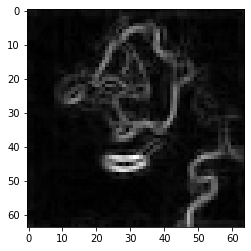

In [ ]:
def grayscale(image):
    grey = np.mean(image, axis = 0)
    return grey
from scipy import ndimage
# image = img_lst[110][0] # single tensor image isolate from batch 
image = img_lst[110][0].detach().cpu().numpy()
image = grayscale(image)
print(image.shape)
#image = grayscale(image)
#image = img_lst[110][0].detach().cpu().numpy()
img_x = ndimage.sobel(image, 0) # sobel operation across horizontal
img_y = ndimage.sobel(image, 1) # sobel operation across vertical
sob = np.hypot(img_x, img_y)
# sob = grayscale(sob)
#sob = np.sum(sob, axis = [-1,-1,-1])
#grad_comp = np.sqrt(img_x + img_y)
#grad_comp = np.sum(grad_comp,axis=-1)
#grad_mag_sqrt = np.sum(grad_comp, axis = -1)
#grad_mag_imge = np.sqrt(grad_mag_sqrt)
#tf.math.reduce_sum(grad_comp,axis=-1)
#image_sobel = np.sqrt((img_x ** 2) + (img_y **2))
# transpose image to obtain correct dimensions
# plot
# plt.imshow(np.transpose(grad_mag_imge,(1,2,0)))
#plt.imshow(np.transpose(grad_comp,(1,2,0)))
plt.imshow(sob, cmap='gray')


torch.Size([3, 64, 64])


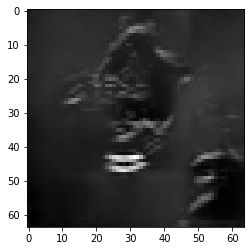

In [ ]:
from scipy import ndimage
image = img_lst[110][0] # single tensor image isolate from batch 
#image = grayscale(image)
print(image.shape)
#image = grayscale(image)
#image = img_lst[110][0].detach().cpu().numpy()
img_x = ndimage.sobel(image, 0) # sobel operation across horizontal
img_y = ndimage.sobel(image, 1) # sobel operation across vertical
sob = np.hypot(img_x, img_y)
sob = grayscale(sob)
# sob = np.sum(sob, axis = [-1,-1,-1])
# grad_comp = np.sqrt(img_x + img_y)
# grad_comp = np.sum(grad_comp,axis=-1)
# grad_mag_sqrt = np.sum(grad_comp, axis = -1)
# grad_mag_imge = np.sqrt(grad_mag_sqrt)
# tf.math.reduce_sum(grad_comp,axis=-1)
# image_sobel = np.sqrt((img_x ** 2) + (img_y **2))
# transpose image to obtain correct dimensions
# plot
# plt.imshow(np.transpose(grad_mag_imge,(1,2,0)))
# plt.imshow(np.transpose(grad_comp,(1,2,0)))
plt.imshow(sob, cmap='gray')

### Save singles of generated images

In [ ]:
# stores a single image
#for j in range(len(img_lst)):
#  for i in range(len(img_lst[j])):
#    torchvision.utils.save_image(img_lst[j][i], '/content/drive/MyDrive/neural_networks/wikiart_gen_imgs/%d%d.JPG' % (j,i), normalize = True)
    #imgs.append((vutils.make_grid(img_lst[j][i].to(device), padding=2, normalize=True).cpu()))
#  if (j % 20 == 0): 
#    print('Stores [%d / %d] image batches' % (j * len(img_lst[0]) , len(img_lst[0])* len(img_lst)))

Stores [0 / 7936] image batches


KeyboardInterrupt: ignored